In [97]:
import sys
import os
from pathlib import Path
import importlib

# Add project root to path
PROJECT_ROOT = Path('/mnt/home/mlee1/vdm_BIND')
sys.path.insert(0, str(PROJECT_ROOT))

# Force reload of bind module to pick up any changes
# This is important if workflow_utils.py was modified since kernel start
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('bind') or mod_name.startswith('vdm'):
        del sys.modules[mod_name]

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import joblib

# Import from our codebase (fresh import after clearing cache)
from bind.workflow_utils import ConfigLoader, ModelManager, sample, load_normalization_stats
from vdm.astro_dataset import get_astro_data

# Setup publication-quality plotting
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Output directory for figures
FIGURE_DIR = PROJECT_ROOT / 'analysis' / 'figures' / 'training'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {FIGURE_DIR}")

Figures will be saved to: /mnt/home/mlee1/vdm_BIND/analysis/figures/training


## Configuration

Select the model type and config to use.

In [143]:
# ============================================================================
# MODEL CONFIGURATION - MODIFY THIS SECTION
# ============================================================================

# Model type options:
#   'clean'        - 3-channel joint VDM (LightCleanVDM)
#   'triple'       - 3 separate 1-channel VDMs (LightTripleVDM)
#   'ddpm'         - DDPM with score_models NCSNpp (DDPMModelWrapper)
#   'dsm'          - Denoising Score Matching with custom UNet (LightDSM)
#   'interpolant'  - Deterministic flow matching (LightInterpolant)
#   'stochastic_interpolant' - Stochastic flow matching (LightInterpolant with sigma>0)
#   'consistency'  - Consistency models for 1-step sampling (LightConsistency)
#   'ot_flow'      - Optimal Transport Flow Matching (LightOTFlow)

MODEL_TYPE = 'clean'  # Options: see above

# Config file path - auto-select based on MODEL_TYPE or set manually
MODEL_CONFIG_MAP = {
    'clean': 'clean_vdm_aggressive_stellar.ini',
    'triple': 'clean_vdm_triple.ini',
    'ddpm': 'ddpm.ini',
    'dsm': 'dsm.ini',
    'interpolant': 'interpolant.ini',
    'stochastic_interpolant': 'stochastic_interpolant.ini',
    'consistency': 'consistency.ini',
    'ot_flow': 'ot_flow.ini',
}

if MODEL_TYPE not in MODEL_CONFIG_MAP:
    raise ValueError(f"Unknown MODEL_TYPE: {MODEL_TYPE}. Use one of: {list(MODEL_CONFIG_MAP.keys())}")

CONFIG_PATH = PROJECT_ROOT / 'configs' / MODEL_CONFIG_MAP[MODEL_TYPE]

# Number of test samples to visualize
N_SAMPLES = 5

# Number of stochastic realizations per sample
N_REALIZATIONS = 4

# Sampling steps configuration per model type
SAMPLING_STEPS_CONFIG = {
    'clean': 1000,       # VDM uses ~250-1000 steps
    'triple': 1000,      # VDM triple uses ~250-1000 steps
    'ddpm': 1000,        # DDPM uses 250-1000 steps
    'dsm': 250,          # DSM uses ~250 steps (same as DDPM)
    'interpolant': 100,  # Deterministic interpolant needs ~50-100 steps
    'stochastic_interpolant': 50,  # Stochastic interpolant ~50 steps
    'consistency': 1,    # Consistency models can use 1-4 steps!
    'ot_flow': 50,       # OT Flow uses ~50 steps
}
SAMPLING_STEPS = SAMPLING_STEPS_CONFIG[MODEL_TYPE]

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Model type: {MODEL_TYPE}")
print(f"Config: {CONFIG_PATH}")
print(f"Device: {DEVICE}")
if MODEL_TYPE in ['ddpm', 'dsm', 'interpolant', 'stochastic_interpolant', 'consistency', 'ot_flow']:
    print(f"Sampling steps: {SAMPLING_STEPS}")

Model type: clean
Config: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_aggressive_stellar.ini
Device: cuda


## Load Model and Test Data

In [144]:
# Load configuration
config = ConfigLoader(str(CONFIG_PATH), verbose=True)

# Resolve relative paths to absolute paths
if hasattr(config, 'quantile_path') and config.quantile_path is not None:
    if not os.path.isabs(config.quantile_path):
        config.quantile_path = str(PROJECT_ROOT / config.quantile_path)
        print(f"Resolved quantile_path to: {config.quantile_path}")

print(f"\nModel: {config.model_name}")
print(f"Checkpoint: {config.best_ckpt}")

[ConfigLoader] Converted legacy_fourier=False to fourier_legacy
[ConfigLoader] conditioning_channels not in config or None, using default: 1
[ConfigLoader] 🌟 Quantile normalization enabled: data/quantile_normalizer_stellar.pkl
[ConfigLoader] Loaded config from: /mnt/home/mlee1/vdm_BIND/configs/clean_vdm_aggressive_stellar.ini
[ConfigLoader] Parameters:
  seed: 8
  dataset: IllustrisTNG
  data_root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
  field: gas
  boxsize: 6.25
  batch_size: 128
  num_workers: 40
  cropsize: 128
  max_epochs: 250
  learning_rate: 5e-05
  lr_scheduler: cosine_warmup
  noise_schedule: learned_nn
  gamma_min: -13.3
  gamma_max: 13.0
  data_noise: (0.0005, 0.0005, 0.0005)
  antithetic_time_sampling: True
  n_blocks: 5
  embedding_dim: 96
  norm_groups: 8
  n_attention_heads: 8
  large_scale_channels: 3
  use_cross_attention: False
  add_attention: True
  use_fourier_features: True
  legacy_fourier: False
  lambdas: 1.0, 1.0, 1.0
  channel_weights: 1.0,

In [145]:
# Load model and test dataloader
# ModelManager now supports all model types: clean, triple, ddpm, dsm, interpolant, 
# stochastic_interpolant, consistency, ot_flow
print("\nLoading model and test data...")
print(f"Configured model type: {MODEL_TYPE}")

# Check that checkpoint exists
if config.best_ckpt is None:
    raise ValueError(f"No checkpoint found for model {config.model_name}")

# ModelManager.initialize() auto-detects model type from config.model_name or checkpoint
test_loader, model = ModelManager.initialize(config, verbose=True, skip_data_loading=False)

# Detect actual model type (may differ from configured if checkpoint is different)
detected_type = ModelManager.detect_model_type(config, verbose=True)
print(f"Detected model type: {detected_type}")

# IMPORTANT: Verify the model class is correct
model_class = type(model).__name__
print(f"\n>>> Model class loaded: {model_class}")

# Model class validation for each type
# Note: 'stochastic_interpolant' uses the same class as 'interpolant' (LightInterpolant)
expected_classes = {
    'ddpm': 'DDPMModelWrapper',
    'dsm': 'LightDSM',
    'interpolant': 'LightInterpolant',
    'stochastic_interpolant': 'LightInterpolant',  # Same class, different config
    'consistency': 'LightConsistency',
    'ot_flow': 'LightOTFlow',
    'clean': 'LightCleanVDM',
    'triple': 'LightTripleVDM',
}

# For stochastic_interpolant, detected_type will be 'interpolant' 
# so we check both MODEL_TYPE and detected_type
expected = expected_classes.get(MODEL_TYPE) or expected_classes.get(detected_type)
if expected and model_class == expected:
    print(f"✓ Correct model class - {model_class}")
    # Extra info for stochastic interpolant
    if MODEL_TYPE == 'stochastic_interpolant' and hasattr(model, 'use_stochastic_interpolant'):
        sigma = getattr(model, 'sigma', getattr(model.hparams, 'sigma', 0.0) if hasattr(model, 'hparams') else 0.0)
        print(f"  Stochastic interpolant: sigma={sigma}")
elif expected:
    print(f"⚠️  Unexpected model class: {model_class} (expected {expected})")
else:
    print(f"  Model class: {model_class}")

# Move model to device
model = model.to(DEVICE)
model.eval()

# Get actual DataLoader from DataModule (for all model types)
actual_loader = test_loader.test_dataloader()
print(f"\n✓ Model loaded successfully")
print(f"Test dataset size: {len(test_loader.dataset)}")

# Update sampling steps for models that support it
if hasattr(model, 'n_sampling_steps'):
    model.n_sampling_steps = SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = SAMPLING_STEPS
    print(f"✓ Set sampling steps to {SAMPLING_STEPS}")

# For consistency models, also set num_steps parameter
if detected_type == 'consistency' and hasattr(model, 'num_steps'):
    model.num_steps = SAMPLING_STEPS
    print(f"✓ Set consistency num_steps to {SAMPLING_STEPS}")


Loading model and test data...
Configured model type: clean
[ModelManager] Defaulting to 'clean' model type
[ModelManager] Initializing CLEAN model (single 3-channel model)...
[ModelManager] Using seed: 8
[ModelManager] Dataset: IllustrisTNG
[ModelManager] Data root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/
[ModelManager] Batch size: 128
[ModelManager] BEFORE auto-detect: conditioning_channels = 1
[ModelManager] BEFORE auto-detect: large_scale_channels = 3
[ModelManager] BEFORE auto-detect: use_fourier_features = True
[ModelManager] BEFORE auto-detect: fourier_legacy = False
[ModelManager] Checkpoint path: /mnt/home/mlee1/ceph/tb_logs2/clean_vdm_aggressive_stellar/version_3//checkpoints/epoch-epoch=002-step=7668.ckpt
[ModelManager] Defaulting to 'clean' model type
[ModelManager] Initializing CLEAN model (single 3-channel model)...
[ModelManager] Using seed: 8
[ModelManager] Dataset: IllustrisTNG
[ModelManager] Data root: /mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/

Seed set to 8


[ModelManager] Using fourier_legacy=False from config file (not auto-detecting)
[ModelManager] New multi-scale Fourier mode channel breakdown:
  Total conv_in: 39
  = input(3) + conditioning(1) + fourier_halo(8) + large_scale(3) + fourier_largescale(24)
[ModelManager] Final channel configuration:
  conditioning_channels: 1
  large_scale_channels: 3
  fourier_legacy: False
[ModelManager] Setting up parameter conditioning...
[ModelManager] Loading dataset (stage='test')...
✓ Loaded DM stats: mean=9.915499, std=0.467967
✓ Loaded Gas stats: mean=9.177344, std=0.410510
✓ Loading quantile transformer from: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
  Quantile transformer loaded (n_quantiles=10000)
  Output distribution: uniform

📊 NORMALIZATION CONFIG (3-channel mode):
  DM input: mean=9.9777, std=0.4139
  DM target: mean=9.9155, std=0.4680
  Gas target: mean=9.1773, std=0.4105
  Stars target: QUANTILE TRANSFORMATION (n_quantiles=10000)
✓ Loaded DM stats: mean=9.915499, st

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ModelManager] Dataset loaded.
[ModelManager] Creating UNetVDM model...
[ModelManager] Model configuration:
  - use_fourier_features: True
  - fourier_legacy: False
  - conditioning_channels: 1
  - large_scale_channels: 3
  - use_cross_attention: False
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)
[ModelManager] UNetVDM created. Wrapping in LightCleanVDM...

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-

/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [146]:
# Load normalization statistics
norm_stats = load_normalization_stats()

# Check if using quantile normalization for stars
use_quantile = hasattr(config, 'quantile_path') and config.quantile_path is not None
if use_quantile:
    quantile_path = config.quantile_path
    # Resolve relative path if needed
    if not os.path.isabs(quantile_path):
        quantile_path = str(PROJECT_ROOT / quantile_path)
    quantile_transformer = joblib.load(quantile_path)
    print(f"Using quantile normalization for stars: {quantile_path}")
else:
    quantile_transformer = None
    print(f"Using Z-score normalization for all channels")

✓ Loaded DM normalization: mean=9.915499, std=0.467967
✓ Loaded Gas normalization: mean=9.177344, std=0.410510
✓ Loaded Stellar normalization: mean=6.995926, std=1.100350
Using quantile normalization for stars: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


## Unnormalization Functions

In [147]:
def unnormalize_field(field, channel_idx, norm_stats, quantile_transformer=None):
    """
    Unnormalize a field from normalized space back to physical units.
    
    IMPORTANT: Train-Test Normalization Mismatch
    ---------------------------------------------
    Some training scripts (train_interpolant.py, train_consistency.py, train_ot_flow.py)
    do NOT read quantile_path from config, so models are trained with Z-score normalization.
    
    However, the inference dataloader DOES read quantile_path and applies quantile 
    normalization to targets.
    
    Result:
    - TARGETS from dataloader: quantile normalized (range [0, 1]) 
    - GENERATED from model: Z-score normalized (range ~[-7, +4])
    
    Usage:
    - For targets: unnormalize_field(target, ch_idx, norm_stats, quantile_transformer)
    - For generated: unnormalize_field(gen, ch_idx, norm_stats, None)  # Force Z-score
    
    See: .github/ISSUES/quantile_normalization_bug.md
    
    Args:
        field: Normalized field (can be 2D or higher)
        channel_idx: 0=DM, 1=Gas, 2=Stars
        norm_stats: Dictionary with normalization statistics
        quantile_transformer: Quantile transformer for stars (use None for Z-score)
    
    Returns:
        Field in physical units (mass density)
    """
    if channel_idx == 0:  # DM
        mean, std = norm_stats['dm_mag_mean'], norm_stats['dm_mag_std']
    elif channel_idx == 1:  # Gas
        mean, std = norm_stats['gas_mag_mean'], norm_stats['gas_mag_std']
    elif channel_idx == 2:  # Stars
        if quantile_transformer is not None:
            # Quantile inverse transform (for targets from dataloader)
            original_shape = field.shape
            field_flat = field.flatten().reshape(-1, 1)
            log_field = quantile_transformer.inverse_transform(field_flat)
            log_field = log_field.reshape(original_shape)
            return 10**log_field - 1
        else:
            # Z-score inverse (for generated outputs from models trained without quantile)
            mean, std = norm_stats['star_mag_mean'], norm_stats['star_mag_std']
    else:
        raise ValueError(f"Unknown channel index: {channel_idx}")
    
    # Z-score inverse: log_field = field * std + mean
    log_field = field * std + mean
    return 10**log_field - 1


def unnormalize_condition(field, norm_stats):
    """
    Unnormalize DM condition field.
    """
    # Use DM condition stats (different from target DM stats)
    mean = norm_stats.get('dm_condition_mean', norm_stats['dm_mag_mean'])
    std = norm_stats.get('dm_condition_std', norm_stats['dm_mag_std'])
    log_field = field * std + mean
    return 10**log_field - 1

## Load Test Samples and Generate Predictions

In [148]:
# Get a batch of test samples
# test_loader is a DataModule, need to get the actual dataloader
if hasattr(test_loader, 'test_dataloader'):
    actual_loader = test_loader.test_dataloader()
elif hasattr(test_loader, 'val_dataloader'):
    actual_loader = test_loader.val_dataloader()
else:
    actual_loader = test_loader

test_iter = iter(actual_loader)
batch = next(test_iter)

# Unpack batch (structure depends on dataset)
if len(batch) == 4:
    # (dm_condition, large_scale, target, params)
    conditions_dm, large_scale, targets, params = batch
    # Concatenate DM condition with large-scale context
    conditions = torch.cat([conditions_dm, large_scale], dim=1)
elif len(batch) == 3:
    conditions, targets, params = batch
elif len(batch) == 2:
    conditions, targets = batch
    params = None
else:
    raise ValueError(f"Unexpected batch structure: {len(batch)} elements")

print(f"Conditions shape: {conditions.shape}")
print(f"Targets shape: {targets.shape}")
if params is not None:
    print(f"Params shape: {params.shape}")

Conditions shape: torch.Size([1, 4, 128, 128])
Targets shape: torch.Size([1, 3, 128, 128])
Params shape: torch.Size([1, 35])


In [149]:
# Select samples to visualize
sample_indices = list(range(min(N_SAMPLES, conditions.shape[0])))

# Extract selected samples
selected_conditions = conditions[sample_indices]
selected_targets = targets[sample_indices]
selected_params = params[sample_indices] if params is not None else None

print(f"Selected {len(sample_indices)} samples for generation")

Selected 1 samples for generation


In [150]:
# Generate predictions
print(f"Generating {N_REALIZATIONS} realizations per sample...")
print(f"Model type: {detected_type}")
print(f"Model class: {type(model).__name__}")

# Verify we have the correct model type
if detected_type == 'ddpm':
    if type(model).__name__ != 'DDPMModelWrapper':
        print(f"\n⚠️  WARNING: Expected DDPMModelWrapper but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells to pick up the fixed ModelManager")
    else:
        print(f"✓ Using correct DDPMModelWrapper")
elif detected_type == 'interpolant':
    if type(model).__name__ != 'LightInterpolant':
        print(f"\n⚠️  WARNING: Expected LightInterpolant but got {type(model).__name__}")
        print("   Please restart kernel and re-run all cells")
    else:
        print(f"✓ Using correct LightInterpolant")

# Move model to device
model = model.to(DEVICE)

# For DDPM/Interpolant models, show and set sampling configuration
if detected_type in ['ddpm', 'interpolant']:
    # Set the sampling steps from our config
    model.n_sampling_steps = 100#SAMPLING_STEPS
    if hasattr(model, 'hparams'):
        model.hparams.n_sampling_steps = 100#SAMPLING_STEPS
    
    print(f"\nSampling configuration:")
    print(f"  SAMPLING_STEPS: {SAMPLING_STEPS}")
    print(f"  model.n_sampling_steps: {model.n_sampling_steps}")
    if hasattr(model, 'hparams'):
        print(f"  model.hparams.n_sampling_steps: {model.hparams.n_sampling_steps}")

# Generate samples
generated = sample(
    model,
    selected_conditions,
    batch_size=N_REALIZATIONS,
    conditional_params=selected_params
)

print(f"\nGenerated shape: {generated.shape}")
print(f"Generated stats: mean={generated.mean():.4f}, std={generated.std():.4f}")
# Shape: (N_SAMPLES, N_REALIZATIONS, 3, H, W)

Generating 4 realizations per sample...
Model type: clean
Model class: LightCleanVDM


Generating Samples:   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2011: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2011: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples: 100%|██████████| 1/1 [00:13<00:00, 13.95s/it]


Generated shape: torch.Size([1, 4, 3, 128, 128])
Generated stats: mean=0.6754, std=1.1932


## Visual Comparison: Input → Generated → Ground Truth

In [130]:
generated[0,0,2], 

(tensor([[-6.1689, -6.6108, -6.3776,  ..., -1.2161, -5.8883, -5.0380],
         [-6.5602, -6.3357, -6.3721,  ..., -0.8355, -1.8700, -6.8083],
         [-6.5299, -6.3620, -6.4133,  ..., -1.9892, -1.2397, -6.8189],
         ...,
         [-6.5073, -6.3476, -6.3634,  ..., -6.4338, -6.3396, -6.5450],
         [-6.5279, -6.2873, -6.3527,  ..., -6.3281, -6.2739, -6.5774],
         [-5.3823, -6.5074, -6.4617,  ..., -6.5116, -6.5095, -6.1030]]),)

In [131]:
generated.shape

torch.Size([1, 4, 3, 128, 128])

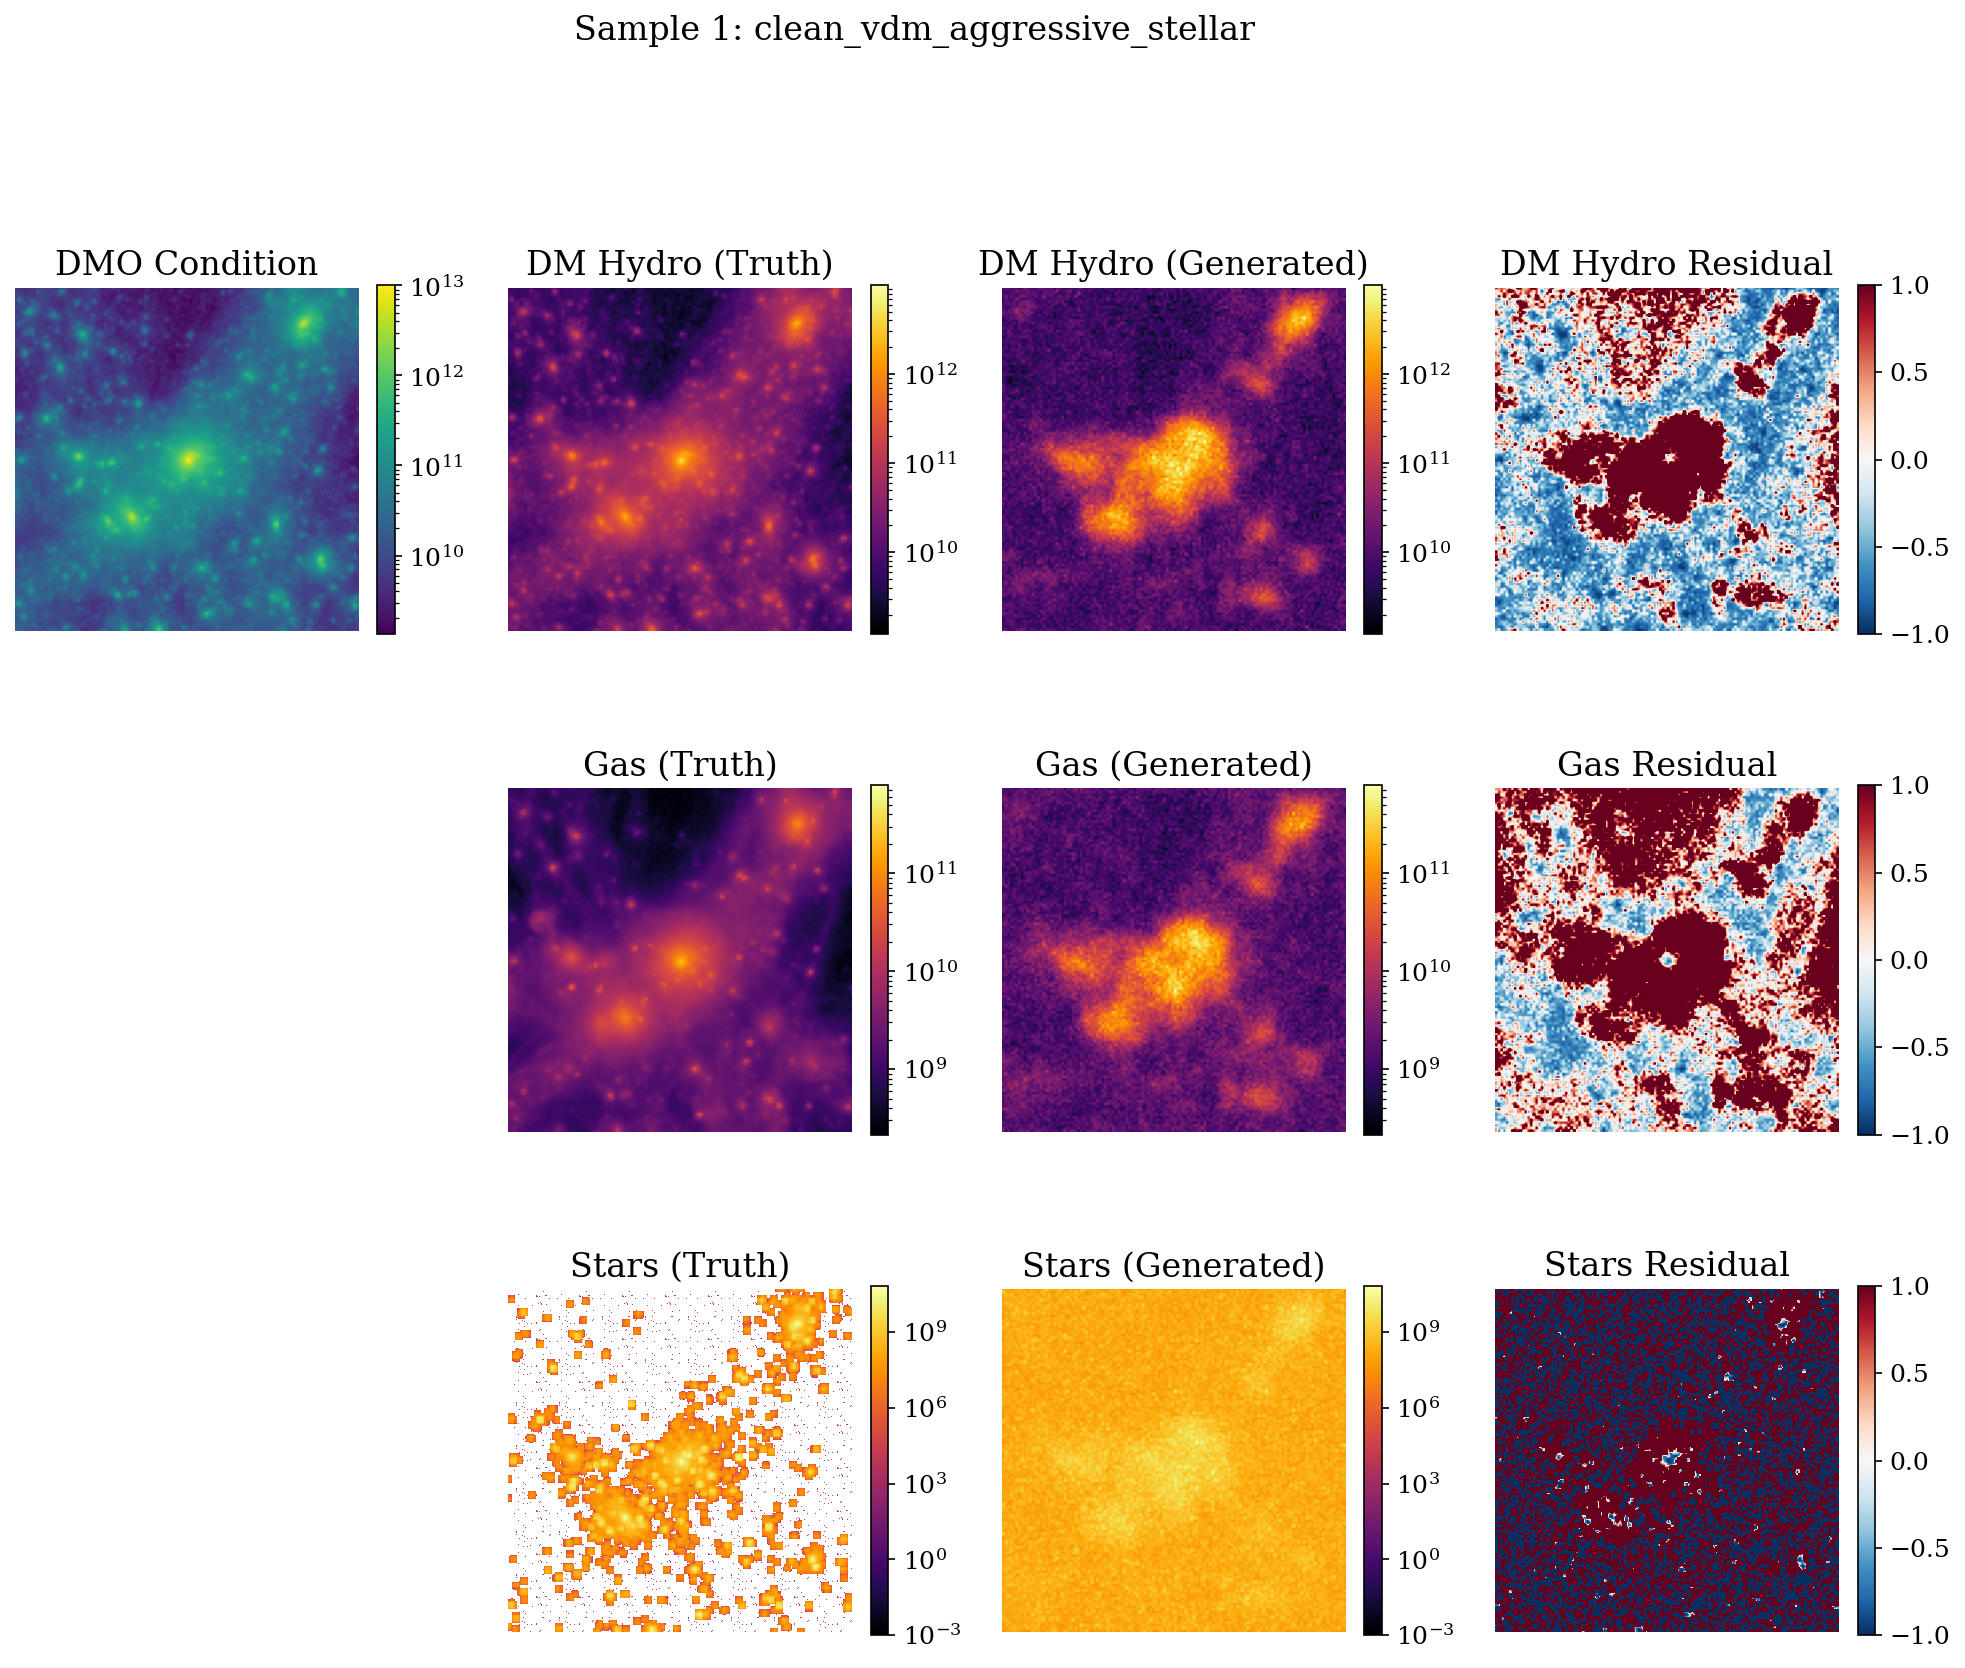


✓ Plotted 1 samples


In [154]:
channel_names = ['DM Hydro', 'Gas', 'Stars']

# Only iterate over actual samples we have
n_samples_to_plot = min(3, len(selected_conditions))

for sample_idx in range(n_samples_to_plot):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)
    
    # Get data for this sample
    condition = selected_conditions[sample_idx].numpy()
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx][0].numpy() # Mean over realizations
    gen_std = generated[sample_idx].std(dim=0).numpy()    # Std over realizations
    
    for ch_idx, ch_name in enumerate(channel_names):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, None)
        
        # Determine color scale
        vmin = max(1e-3, min(target_unnorm.min(), gen_unnorm.min()))
        vmax = max(target_unnorm.max(), gen_unnorm.max())
        norm = LogNorm(vmin=vmin, vmax=vmax)
        
        # Column 1: Condition (only show once, or DM channel)
        if ch_idx == 0:
            ax = fig.add_subplot(gs[ch_idx, 0])
            cond_unnorm = unnormalize_condition(condition[0], norm_stats)
            im = ax.imshow(cond_unnorm, cmap='viridis', norm=LogNorm())
            ax.set_title('DMO Condition')
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046)
        else:
            ax = fig.add_subplot(gs[ch_idx, 0])
            ax.axis('off')
        
        # Column 2: Ground Truth
        ax = fig.add_subplot(gs[ch_idx, 1])
        im = ax.imshow(target_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Truth)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 3: Generated (mean)
        ax = fig.add_subplot(gs[ch_idx, 2])
        im = ax.imshow(gen_unnorm, cmap='inferno', norm=norm)
        ax.set_title(f'{ch_name} (Generated)')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
        
        # Column 4: Residual
        ax = fig.add_subplot(gs[ch_idx, 3])
        residual = (gen_unnorm - target_unnorm) / (target_unnorm + 1e-10)
        im = ax.imshow(residual, cmap='RdBu_r', vmin=-1, vmax=1)
        ax.set_title(f'{ch_name} Residual')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f'Sample {sample_idx + 1}: {config.model_name}', fontsize=16, y=1.02)
    
    # Save figure
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_comparison.png'))
    plt.show()

print(f"\n✓ Plotted {n_samples_to_plot} samples")

## Radial Density Profiles

Compute azimuthally-averaged density profiles around halo centers.

In [155]:
2556*4 * 32

327168

In [156]:
def compute_radial_profile(image, center=None, n_bins=50, r_max=None):
    """
    Compute azimuthally-averaged radial profile.
    
    Args:
        image: 2D array
        center: (y, x) center coordinates. If None, use image center.
        n_bins: Number of radial bins
        r_max: Maximum radius. If None, use half the image size.
    
    Returns:
        r_bins: Radial bin centers
        profile: Mean value in each radial bin
        profile_std: Standard deviation in each radial bin
    """
    ny, nx = image.shape
    
    if center is None:
        center = (ny // 2, nx // 2)
    
    if r_max is None:
        r_max = min(ny, nx) // 2
    
    # Create coordinate grids
    y, x = np.ogrid[:ny, :nx]
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Create radial bins
    r_bins = np.linspace(0, r_max, n_bins + 1)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Compute profile
    profile = np.zeros(n_bins)
    profile_std = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = (r >= r_bins[i]) & (r < r_bins[i+1])
        if mask.sum() > 0:
            profile[i] = np.mean(image[mask])
            profile_std[i] = np.std(image[mask])
    
    return r_centers, profile, profile_std

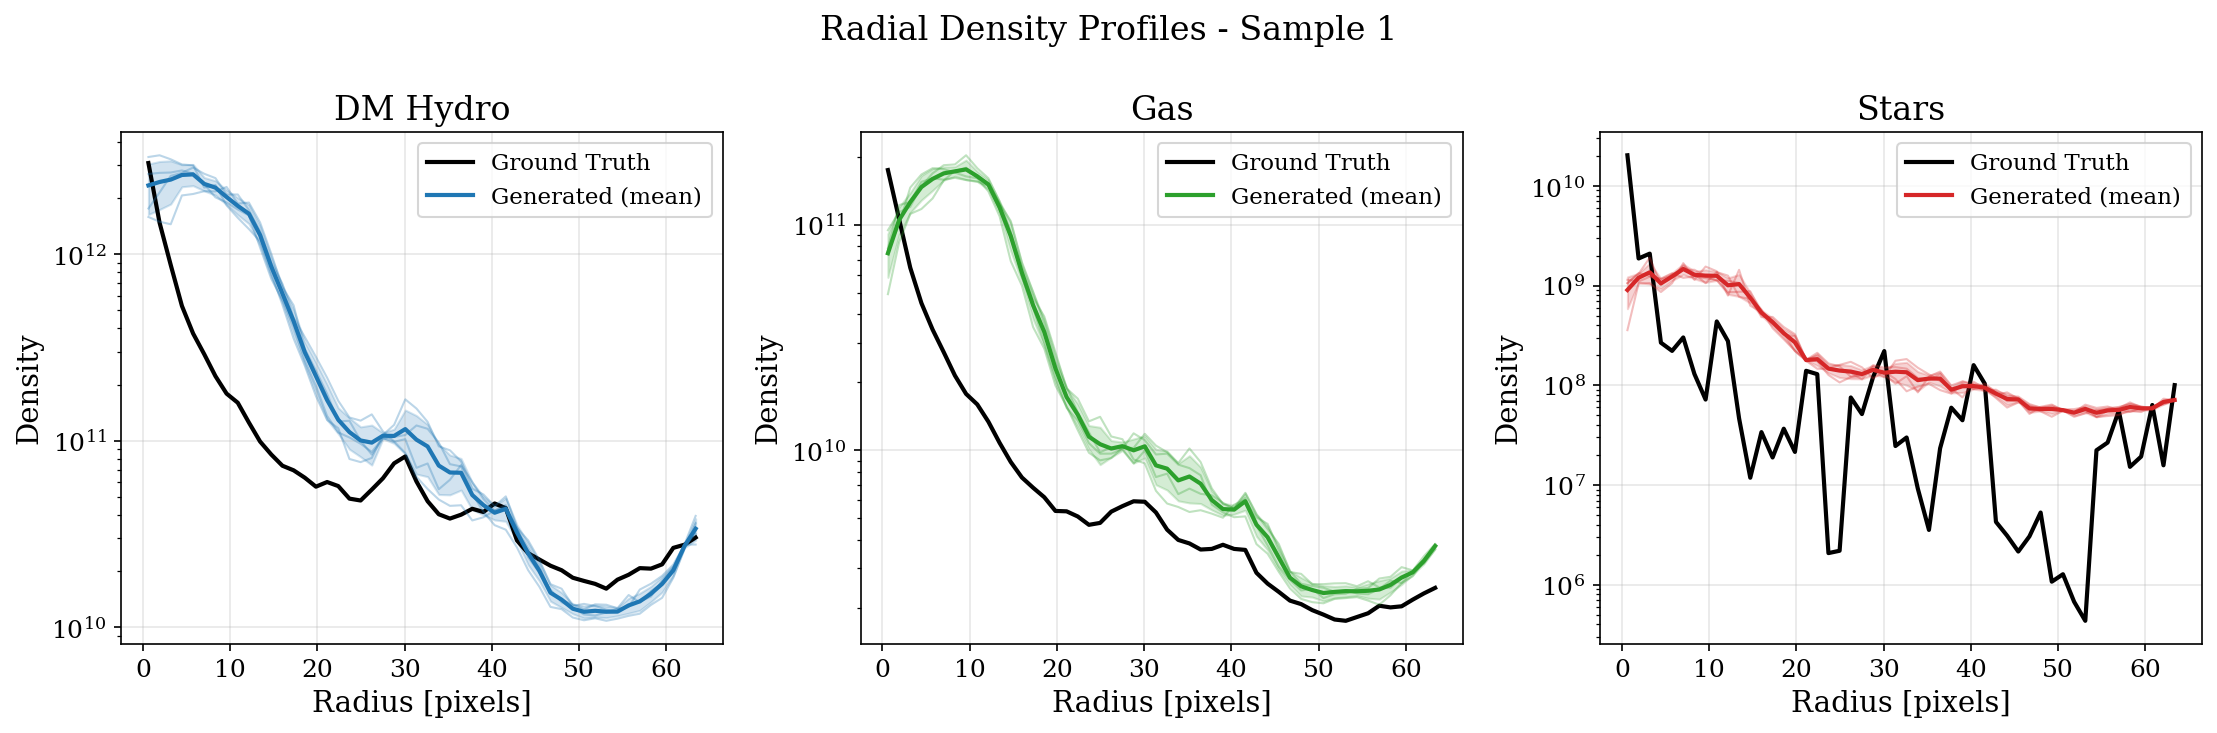

In [157]:
# Compute and plot radial profiles for each sample
channel_colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

for sample_idx in range(min(1, N_SAMPLES)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    target = selected_targets[sample_idx].numpy()
    gen_samples = generated[sample_idx].numpy()  # (N_REALIZATIONS, 3, H, W)
    
    for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
        # Unnormalize
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        # Ground truth profile
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        ax.plot(r, profile_true, 'k-', linewidth=2, label='Ground Truth')
        
        # Generated profiles (multiple realizations)
        gen_profiles = []
        for real_idx in range(N_REALIZATIONS):
            gen_unnorm = unnormalize_field(gen_samples[real_idx, ch_idx], ch_idx, norm_stats, None)
            r, profile_gen, _ = compute_radial_profile(gen_unnorm)
            gen_profiles.append(profile_gen)
            ax.plot(r, profile_gen, '-', color=channel_colors[ch_idx], 
                   alpha=0.3, linewidth=1)
        
        # Mean generated profile
        gen_profiles = np.array(gen_profiles)
        gen_mean = gen_profiles.mean(axis=0)
        gen_std = gen_profiles.std(axis=0)
        
        ax.plot(r, gen_mean, '-', color=channel_colors[ch_idx], 
               linewidth=2, label='Generated (mean)')
        ax.fill_between(r, gen_mean - gen_std, gen_mean + gen_std, 
                       color=channel_colors[ch_idx], alpha=0.2)
        
        ax.set_xlabel('Radius [pixels]')
        ax.set_ylabel('Density')
        ax.set_title(ch_name)
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Radial Density Profiles - Sample {sample_idx + 1}', fontsize=16)
    plt.tight_layout()
    
    fig.savefig(str(FIGURE_DIR / f'{config.model_name}_sample_{sample_idx}_profiles.png'))
    plt.show()

## Profile Residuals Analysis

In [64]:
# Aggregate profiles across all samples
all_residuals = {ch: [] for ch in channel_names}

for sample_idx in range(min(1, N_SAMPLES)):
    target = selected_targets[sample_idx].numpy()
    gen_mean = generated[sample_idx].mean(dim=0).numpy()
    
    for ch_idx, ch_name in enumerate(channel_names):
        target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, quantile_transformer)
        gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, quantile_transformer)
        
        r, profile_true, _ = compute_radial_profile(target_unnorm)
        _, profile_gen, _ = compute_radial_profile(gen_unnorm)
        
        residual = (profile_gen - profile_true) / (profile_true + 1e-10)
        all_residuals[ch_name].append(residual)

# Convert to arrays
for ch_name in channel_names:
    all_residuals[ch_name] = np.array(all_residuals[ch_name])

Using quantile inverse transform for stars
Using quantile inverse transform for stars


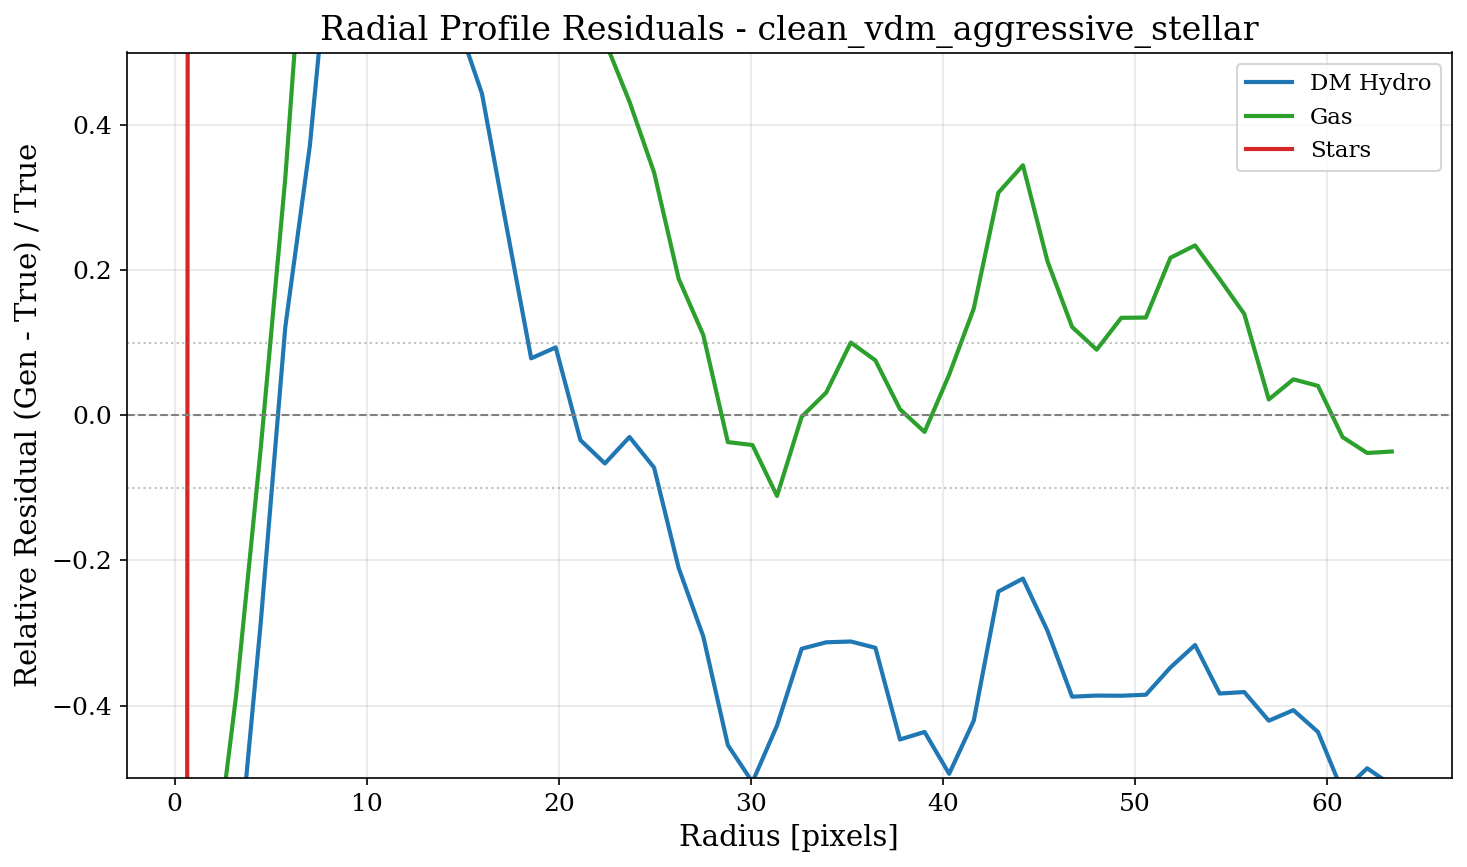

In [65]:
# Plot aggregated residuals
fig, ax = plt.subplots(figsize=(10, 6))

for ch_idx, (ch_name, color) in enumerate(zip(channel_names, channel_colors)):
    residuals = all_residuals[ch_name]
    mean_res = residuals.mean(axis=0)
    std_res = residuals.std(axis=0)
    
    ax.plot(r, mean_res, '-', color=color, linewidth=2, label=ch_name)
    ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                   color=color, alpha=0.2)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Radius [pixels]')
ax.set_ylabel('Relative Residual (Gen - True) / True')
ax.set_title(f'Radial Profile Residuals - {config.model_name}')
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(str(FIGURE_DIR / f'{config.model_name}_profile_residuals.png'))
plt.show()

## Summary Statistics

In [48]:
print(f"\n{'='*60}")
print(f"Validation Summary: {config.model_name}")
print(f"{'='*60}\n")

print(f"Model type: {detected_type}")
print(f"Test samples evaluated: {N_SAMPLES}")
print(f"Realizations per sample: {N_REALIZATIONS}")
if detected_type in ['ddpm', 'interpolant']:
    print(f"Sampling steps: {SAMPLING_STEPS}")
print()

print("Mean Absolute Relative Error (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    mare = np.abs(residuals).mean()
    print(f"  {ch_name}: {mare:.4f} ({mare*100:.2f}%)")

print("\nBias (by channel):")
for ch_name in channel_names:
    residuals = all_residuals[ch_name]
    bias = residuals.mean()
    print(f"  {ch_name}: {bias:+.4f} ({bias*100:+.2f}%)")


Validation Summary: dsm_3ch

Model type: dsm
Test samples evaluated: 5
Realizations per sample: 4

Mean Absolute Relative Error (by channel):
  DM Hydro: 0.0589 (5.89%)
  Gas: 0.4123 (41.23%)
  Stars: 0.8072 (80.72%)

Bias (by channel):
  DM Hydro: -0.0587 (-5.87%)
  Gas: +0.4123 (+41.23%)
  Stars: -0.5112 (-51.12%)


## Compare Multiple Models (Optional)

In [18]:
# ============================================================================
# MODEL COMPARISON - Set to True to enable
# ============================================================================

COMPARE_MODELS = True

# Sampling steps for different model types
SAMPLING_STEPS_CONFIG = {
    'clean': 1000,       # VDM uses ~250-1000 steps
    'triple': 1000,      # VDM triple uses ~250-1000 steps  
    'ddpm': 1000,        # DDPM uses 250-1000 steps
    'dsm': 250,          # DSM uses ~250 steps (same as DDPM)
    'interpolant': 100,  # Deterministic interpolant ~50-100 steps
    'stochastic_interpolant': 50,  # Stochastic interpolant ~50 steps
    'consistency': 1,    # Consistency models can use 1-4 steps!
    'ot_flow': 50,       # OT Flow uses ~50 steps
}

if COMPARE_MODELS:
    # List of configs to compare: (config_file, label, model_type)
    # All 8 model types are now supported!
    CONFIGS_TO_COMPARE = [
        ('clean_vdm_aggressive_stellar.ini', 'VDM Clean', 'clean'),
        ('clean_vdm_triple.ini', 'VDM Triple', 'triple'),
        ('ddpm.ini', 'DDPM NCSNpp', 'ddpm'),
        ('dsm.ini', 'DSM', 'dsm'),
        ('interpolant.ini', 'Interpolant', 'interpolant'),
        ('stochastic_interpolant.ini', 'Stoch. Interpolant', 'stochastic_interpolant'),
        ('consistency.ini', 'Consistency', 'consistency'),
        ('ot_flow.ini', 'OT Flow', 'ot_flow'),
    ]
    
    comparison_results = {}
    
    for config_file, label, mtype in CONFIGS_TO_COMPARE:
        config_path = PROJECT_ROOT / 'configs' / config_file
        if not config_path.exists():
            print(f"Config not found: {config_path}")
            continue
            
        print(f"\n{'='*60}")
        print(f"Loading {label} ({mtype})...")
        print(f"{'='*60}")
        
        cfg = ConfigLoader(str(config_path), verbose=False)
        
        # Skip if no checkpoint exists
        if cfg.best_ckpt is None:
            print(f"  ⚠️  No checkpoint found, skipping...")
            continue
        
        print(f"  Checkpoint: {cfg.best_ckpt}")
        
        # Resolve quantile path and load quantile transformer for this specific model
        model_quantile_transformer = None
        if hasattr(cfg, 'quantile_path') and cfg.quantile_path is not None:
            qt_path = cfg.quantile_path
            if not os.path.isabs(qt_path):
                qt_path = str(PROJECT_ROOT / qt_path)
            cfg.quantile_path = qt_path
            if os.path.exists(qt_path):
                model_quantile_transformer = joblib.load(qt_path)
                print(f"  ✓ Loaded quantile transformer: {qt_path}")
            else:
                print(f"  ⚠️  Quantile path not found: {qt_path}")
        else:
            print(f"  Using Z-score normalization for stars (no quantile transformer)")
        
        # Load model - ModelManager auto-detects type
        try:
            _, mdl = ModelManager.initialize(cfg, verbose=False, skip_data_loading=True)
            mdl = mdl.to(DEVICE)
            mdl.eval()
        except Exception as e:
            print(f"  ⚠️  Failed to load model: {e}")
            continue
        
        # Set sampling steps based on model type
        sampling_steps = SAMPLING_STEPS_CONFIG.get(mtype, 250)
        if hasattr(mdl, 'n_sampling_steps'):
            mdl.n_sampling_steps = sampling_steps
            if hasattr(mdl, 'hparams'):
                mdl.hparams.n_sampling_steps = sampling_steps
        if mtype == 'consistency' and hasattr(mdl, 'num_steps'):
            mdl.num_steps = sampling_steps
        print(f"  Using {sampling_steps} sampling steps")
        
        # Generate predictions
        print(f"  Generating {N_REALIZATIONS} realizations...")
        import time
        start_time = time.time()
        
        with torch.no_grad():
            gen = sample(mdl, selected_conditions, batch_size=N_REALIZATIONS,
                        conditional_params=selected_params)
        
        gen_time = time.time() - start_time
        print(f"  Generation time: {gen_time:.1f}s ({gen_time/len(selected_conditions):.1f}s per sample)")
        
        # Compute metrics - USE THE MODEL-SPECIFIC quantile_transformer!
        residuals = {ch: [] for ch in channel_names}
        pixel_mse = {ch: [] for ch in channel_names}
        
        for sample_idx in range(min(N_SAMPLES, len(selected_targets))):
            target = selected_targets[sample_idx].numpy()
            gen_mean = gen[sample_idx].mean(dim=0).numpy()
            
            for ch_idx, ch_name in enumerate(channel_names):
                # Use model-specific quantile_transformer for this model
                target_unnorm = unnormalize_field(target[ch_idx], ch_idx, norm_stats, model_quantile_transformer)
                gen_unnorm = unnormalize_field(gen_mean[ch_idx], ch_idx, norm_stats, model_quantile_transformer)
                
                # Radial profile residual
                r, profile_true, _ = compute_radial_profile(target_unnorm)
                _, profile_gen, _ = compute_radial_profile(gen_unnorm)
                residual = (profile_gen - profile_true) / (profile_true + 1e-10)
                residuals[ch_name].append(residual)
                
                # Pixel-wise MSE (in log space)
                log_target = np.log10(target_unnorm + 1)
                log_gen = np.log10(gen_unnorm + 1)
                mse = np.mean((log_target - log_gen)**2)
                pixel_mse[ch_name].append(mse)
        
        comparison_results[label] = {
            'residuals': {ch: np.array(v) for ch, v in residuals.items()},
            'pixel_mse': {ch: np.mean(v) for ch, v in pixel_mse.items()},
            'gen_time': gen_time,
            'model_type': mtype,
            'sampling_steps': sampling_steps,
        }
        print(f"  ✓ Complete")
        
        # Clean up GPU memory
        del mdl
        torch.cuda.empty_cache()
    
    # ==================== RESULTS SUMMARY ====================
    if comparison_results:
        print(f"\n{'='*80}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*80}")
        
        # Print table header
        print(f"\n{'Model':<20} {'Type':<18} {'Steps':<8} {'Time(s)':<10} {'DM MSE':<10} {'Gas MSE':<10} {'Star MSE':<10}")
        print("-" * 96)
        
        for label, results in comparison_results.items():
            mtype = results['model_type']
            steps = results['sampling_steps']
            gen_time = results['gen_time']
            dm_mse = results['pixel_mse']['DM Hydro']
            gas_mse = results['pixel_mse']['Gas']
            star_mse = results['pixel_mse']['Stars']
            print(f"{label:<20} {mtype:<18} {steps:<8} {gen_time:<10.1f} {dm_mse:<10.4f} {gas_mse:<10.4f} {star_mse:<10.4f}")
        
        # ==================== PROFILE RESIDUALS PLOT ====================
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Color scheme for different model types (8 models)
        color_map = {
            'VDM Clean': '#1f77b4',           # Blue
            'VDM Triple': '#2ca02c',          # Green
            'DDPM NCSNpp': '#d62728',         # Red
            'DSM': '#e377c2',                 # Pink
            'Interpolant': '#9467bd',         # Purple
            'Stoch. Interpolant': '#8c564b',  # Brown
            'Consistency': '#ff7f0e',         # Orange
            'OT Flow': '#17becf',             # Cyan
        }
        
        for ch_idx, (ax, ch_name) in enumerate(zip(axes, channel_names)):
            for label, results in comparison_results.items():
                residuals = results['residuals'][ch_name]
                mean_res = residuals.mean(axis=0)
                std_res = residuals.std(axis=0)
                color = color_map.get(label, 'gray')
                
                ax.plot(r, mean_res, '-', linewidth=2, label=label, color=color)
                ax.fill_between(r, mean_res - std_res, mean_res + std_res, 
                               alpha=0.15, color=color)
            
            ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.1, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.axhline(y=-0.1, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
            ax.set_xlabel('Radius [pixels]')
            ax.set_ylabel('Relative Residual')
            ax.set_title(ch_name)
            ax.set_ylim(-0.5, 0.5)
            ax.legend(fontsize=7, loc='best')
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Model Comparison: Radial Profile Residuals', fontsize=16)
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_profiles.png'), dpi=150)
        plt.show()
        
        # ==================== MSE BAR CHART ====================
        fig, ax = plt.subplots(figsize=(14, 6))
        
        models = list(comparison_results.keys())
        x = np.arange(len(models))
        width = 0.25
        
        dm_mse = [comparison_results[m]['pixel_mse']['DM Hydro'] for m in models]
        gas_mse = [comparison_results[m]['pixel_mse']['Gas'] for m in models]
        star_mse = [comparison_results[m]['pixel_mse']['Stars'] for m in models]
        
        ax.bar(x - width, dm_mse, width, label='DM Hydro', color='#1f77b4')
        ax.bar(x, gas_mse, width, label='Gas', color='#2ca02c')
        ax.bar(x + width, star_mse, width, label='Stars', color='#d62728')
        
        ax.set_xlabel('Model')
        ax.set_ylabel('Log-space MSE')
        ax.set_title('Pixel-wise MSE by Model and Channel')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=25, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_mse.png'), dpi=150)
        plt.show()
        
        # ==================== GENERATION TIME COMPARISON ====================
        fig, ax = plt.subplots(figsize=(12, 5))
        
        times = [comparison_results[m]['gen_time'] for m in models]
        colors = [color_map.get(m, 'gray') for m in models]
        
        bars = ax.bar(models, times, color=colors)
        ax.set_xlabel('Model')
        ax.set_ylabel('Generation Time (s)')
        ax.set_title(f'Generation Time ({N_SAMPLES} samples, {N_REALIZATIONS} realizations)')
        ax.tick_params(axis='x', rotation=25)
        
        # Add value labels on bars
        for bar, t in zip(bars, times):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{t:.1f}s', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        fig.savefig(str(FIGURE_DIR / 'model_comparison_time.png'), dpi=150)
        plt.show()
        
    else:
        print("\n⚠️  No models with checkpoints found for comparison.")


Loading VDM Clean (clean)...
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs/clean_vdm_aggressive_stellar/version_3//checkpoints/epoch=218-step=139941-val/elbo=3.878.ckpt
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs/clean_vdm_aggressive_stellar/version_3//checkpoints/epoch=218-step=139941-val/elbo=3.878.ckpt


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


  ✓ Loaded quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


Seed set to 8


✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]


/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2060: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16):


✓ Final decoder channels: 64 (GroupNorm groups: 8)
✓ Parameter predictor added (predicts 35 params)

INITIALIZING CLEAN VDM MODEL

📊 MODEL CONFIGURATION:
  Image shape: (3, 128, 128)
  Noise schedule: learned_nn
  Gamma range: [-13.3, 13.0]
  Data noise (per-channel): (0.0005, 0.0005, 0.0005)
  Loss weights (diffusion, latent, recons): 1.0, 1.0, 1.0

🎯 CHANNEL WEIGHTS: (1, 1, 1)

✓ Parameter prediction enabled (weight=0.01)


  Using 1000 sampling steps
  Generating 4 realizations...


Generating Samples (1000 steps):   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (1000 steps): 100%|██████████| 1/1 [00:13<00:00, 13.14s/it]



  Generation time: 13.1s (13.1s per sample)
  ✓ Complete

Loading VDM Triple (triple)...


/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Seed set to 42


  Checkpoint: /mnt/home/mlee1/ceph/tb_logs/triple_vdm_separate_models/version_4//checkpoints/epoch=113-step=665874-val/elbo=-5.514.ckpt
  ✓ Loaded quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 37
✓ Parameter conditioning enabled:


Seed set to 8


  ⚠️  Failed to load model: 'LightTripleVDM' object has no attribute 'hydro_dm_score_model'

Loading DDPM NCSNpp (ddpm)...
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs/ddpm_ncsnpp_vp/version_1//checkpoints/epoch-epoch=049-step=63900.ckpt
  ✓ Loaded quantile transformer: /mnt/home/mlee1/vdm_BIND/data/quantile_normalizer_stellar.pkl


/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2060: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16):


  Using 1000 sampling steps
  Generating 4 realizations...


Generating Samples (1000 steps):   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')

/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 1.6e+00: 100%|██████████| 1000/1000 [00:28<00:00, 35.45it/s]
Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 1.6e+00: 100%|██████████| 1000/1000 [00:28<00:00, 35.45it/s]
Generating Samples (1000 steps): 100%|██████████| 1/1 [00:28<00:00, 28.22s/it]

Seed set to 8
Seed 

  Generation time: 28.2s (28.2s per sample)
  ✓ Complete

Loading DSM (dsm)...
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs//dsm_3ch/version_0//checkpoints/epoch-epoch=007-step=2560.ckpt
  Using Z-score normalization for stars (no quantile transformer)
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter conditioning enabled:
  - Time embedding dim: 384
  - Param embedding dim: 384
  - Total condition dim: 768
✓ Channel progression (encoder): [96, 192, 384, 768, 1024]
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1, 2, 4, 8]π -> 8 features per channel
  - Large-scale: Low frequencies [0.25, 0.5, 1, 2]π -> 8 features per channel
  - Target: No Fourier features (learns naturally)
  - Total input channels: 39
✓ Parameter co

/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2060: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16):


  Using 250 sampling steps
  Generating 4 realizations...


Generating Samples (250 steps):   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (250 steps): 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]



  Generation time: 3.3s (3.3s per sample)
  ✓ Complete

Loading Interpolant (interpolant)...


Seed set to 8


  Checkpoint: /mnt/home/mlee1/ceph/tb_logs//interpolant_3ch/version_0/version_5/checkpoints/epoch-epoch=013-step=4480.ckpt
  Using Z-score normalization for stars (no quantile transformer)


Seed set to 8


  ⚠️  Failed to load model: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 43.00 MiB is free. Process 3548840 has 9.11 GiB memory in use. Process 3626841 has 9.93 GiB memory in use. Including non-PyTorch memory, this process has 20.46 GiB memory in use. Of the allocated memory 19.95 GiB is allocated by PyTorch, and 11.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Loading Stoch. Interpolant (stochastic_interpolant)...
  Checkpoint: /mnt/home/mlee1/ceph/tb_logs//stochastic_interpolant_3ch/version_0/version_0/checkpoints/epoch-epoch=013-step=4480.ckpt
  Using Z-score normalization for stars (no quantile transformer)
✓ Scale-appropriate Fourier features enabled:
  - Halo (m_dm): High frequencies [1

/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2060: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16):


  Using 50 sampling steps
  Generating 4 realizations...


Generating Samples (50 steps):   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (50 steps):   0%|          | 0/1 [00:00<?, ?it/s]/mnt/home/mlee1/vdm_BIND/bind/workflow_utils.py:2082: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param_row = torch.tensor(conditional_params[i], dtype=torch.float32, device='cuda')
Generating Samples (50 steps):   0%|          | 0/1 [00:00<?, ?it/s]



OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 37.00 MiB is free. Process 3548840 has 9.11 GiB memory in use. Process 3626841 has 9.93 GiB memory in use. Including non-PyTorch memory, this process has 20.47 GiB memory in use. Of the allocated memory 19.88 GiB is allocated by PyTorch, and 87.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 7. Data Analysis: Why Gas Over-Predicts and Stars Are Poorly Constrained

This analysis investigates the **physics-driven challenges** that affect all model architectures equally, explaining why:
1. **Gas is consistently over-predicted** regardless of model type
2. **Stellar channel is poorly constrained** with high variance in predictions

In [45]:
# Load training data for analysis
import glob

data_root = '/mnt/home/mlee1/ceph/train_data_rotated2_128_cpu/train/'

# Load from multiple simulations for statistical significance
files = []
for sim in range(10):  # 10 simulations
    files.extend(sorted(glob.glob(f'{data_root}/sim_{sim}/*.npz'))[:20])

print(f"📊 Analyzing {len(files)} training samples from 10 simulations")

# Collect raw field data
all_dm_cond = []
all_dm_tgt = []
all_gas = []
all_star = []
star_sparsity = []
correlations = []

for f in files:
    data = np.load(f)
    cond = data['condition']   # DMO condition
    target = data['target']    # Target [DM_hydro, Gas, Stars]
    
    all_dm_cond.append(cond)
    all_dm_tgt.append(target[0])
    all_gas.append(target[1])
    all_star.append(target[2])
    
    # Stellar sparsity
    star_sparsity.append((target[2] < 1).mean())
    
    # Pixel-wise correlations
    dm_flat = target[0].flatten()
    gas_flat = target[1].flatten()
    star_flat = target[2].flatten()
    corr_dm_gas = np.corrcoef(dm_flat, gas_flat)[0,1]
    corr_dm_star = np.corrcoef(dm_flat, star_flat)[0,1]
    correlations.append((corr_dm_gas, corr_dm_star))

all_dm_cond = np.array(all_dm_cond)
all_dm_tgt = np.array(all_dm_tgt)
all_gas = np.array(all_gas)
all_star = np.array(all_star)
correlations = np.array(correlations)

print(f"✅ Loaded data shapes: DM={all_dm_tgt.shape}, Gas={all_gas.shape}, Stars={all_star.shape}")

📊 Analyzing 180 training samples from 10 simulations
✅ Loaded data shapes: DM=(180, 128, 128), Gas=(180, 128, 128), Stars=(180, 128, 128)


In [47]:
# Compute key statistics
print("=" * 70)
print("📊 RAW DATA STATISTICS")
print("=" * 70)

print(f"\n1. FIELD VALUE STATISTICS (raw, before normalization):")
print(f"   DM (DMO):   mean={all_dm_cond.mean():.2e}, std={all_dm_cond.std():.2e}")
print(f"   DM (Hydro): mean={all_dm_tgt.mean():.2e}, std={all_dm_tgt.std():.2e}")
print(f"   Gas:        mean={all_gas.mean():.2e}, std={all_gas.std():.2e}")
print(f"   Stars:      mean={all_star.mean():.2e}, std={all_star.std():.2e}")

print(f"\n2. PIXEL-WISE CORRELATION WITH DM:")
print(f"   Gas-DM correlation:  {correlations[:,0].mean():.3f} ± {correlations[:,0].std():.3f}")
print(f"   Star-DM correlation: {correlations[:,1].mean():.3f} ± {correlations[:,1].std():.3f}")
print(f"   → Gas follows DM {correlations[:,0].mean()/correlations[:,1].mean():.2f}x more closely than stars")

print(f"\n3. STELLAR SPARSITY ANALYSIS:")
print(f"   Zero pixels (< 1):    {np.mean(star_sparsity)*100:.1f}%")
print(f"   Very low (< 1e5):     {(all_star < 1e5).mean()*100:.1f}%")
print(f"   Low (< 1e7):          {(all_star < 1e7).mean()*100:.1f}%")
print(f"   Moderate (1e7-1e9):   {((all_star >= 1e7) & (all_star < 1e9)).mean()*100:.1f}%")
print(f"   High (>= 1e9):        {(all_star >= 1e9).mean()*100:.1f}%")

# Log-space statistics
log_dm_cond = np.log10(all_dm_cond + 1)
log_dm = np.log10(all_dm_tgt + 1)
log_gas = np.log10(all_gas + 1)
log_star = np.log10(all_star + 1)

print(f"\n4. DYNAMIC RANGE IN LOG SPACE:")
print(f"   DM spans:   {log_dm.max() - log_dm.min():.1f} decades [{log_dm.min():.1f}, {log_dm.max():.1f}]")
print(f"   Gas spans:  {log_gas.max() - log_gas.min():.1f} decades [{log_gas.min():.1f}, {log_gas.max():.1f}]")
print(f"   Stars span: {log_star.max() - log_star.min():.1f} decades [{log_star.min():.1f}, {log_star.max():.1f}]")

# Spatial concentration
print(f"\n5. SPATIAL CONCENTRATION (top 5% pixels contain how much mass):")
for i in range(min(5, len(all_dm_tgt))):
    dm_top5 = np.sort(all_dm_tgt[i].flatten())[-int(0.05*all_dm_tgt[i].size):].sum() / all_dm_tgt[i].sum()
    gas_top5 = np.sort(all_gas[i].flatten())[-int(0.05*all_gas[i].size):].sum() / all_gas[i].sum()
    star_sum = all_star[i].sum()
    star_top5 = np.sort(all_star[i].flatten())[-int(0.05*all_star[i].size):].sum() / star_sum if star_sum > 0 else 0
    print(f"   Sample {i}: DM={dm_top5*100:.0f}%, Gas={gas_top5*100:.0f}%, Stars={star_top5*100:.0f}%")

📊 RAW DATA STATISTICS

1. FIELD VALUE STATISTICS (raw, before normalization):
   DM (DMO):   mean=3.02e+10, std=1.08e+11
   DM (Hydro): mean=2.59e+10, std=9.86e+10
   Gas:        mean=4.19e+09, std=8.90e+09
   Stars:      mean=1.31e+08, std=2.99e+09

2. PIXEL-WISE CORRELATION WITH DM:
   Gas-DM correlation:  0.875 ± 0.048
   Star-DM correlation: 0.688 ± 0.051
   → Gas follows DM 1.27x more closely than stars

3. STELLAR SPARSITY ANALYSIS:
   Zero pixels (< 1):    74.7%
   Very low (< 1e5):     75.4%
   Low (< 1e7):          87.8%
   Moderate (1e7-1e9):   10.8%
   High (>= 1e9):        1.4%

4. DYNAMIC RANGE IN LOG SPACE:
   DM spans:   4.6 decades [8.5, 13.0]
   Gas spans:  4.0 decades [7.7, 11.6]
   Stars span: 11.9 decades [0.0, 11.9]

5. SPATIAL CONCENTRATION (top 5% pixels contain how much mass):
   Sample 0: DM=42%, Gas=34%, Stars=87%
   Sample 1: DM=40%, Gas=32%, Stars=87%
   Sample 2: DM=43%, Gas=35%, Stars=91%
   Sample 3: DM=40%, Gas=32%, Stars=86%
   Sample 4: DM=44%, Gas=35%

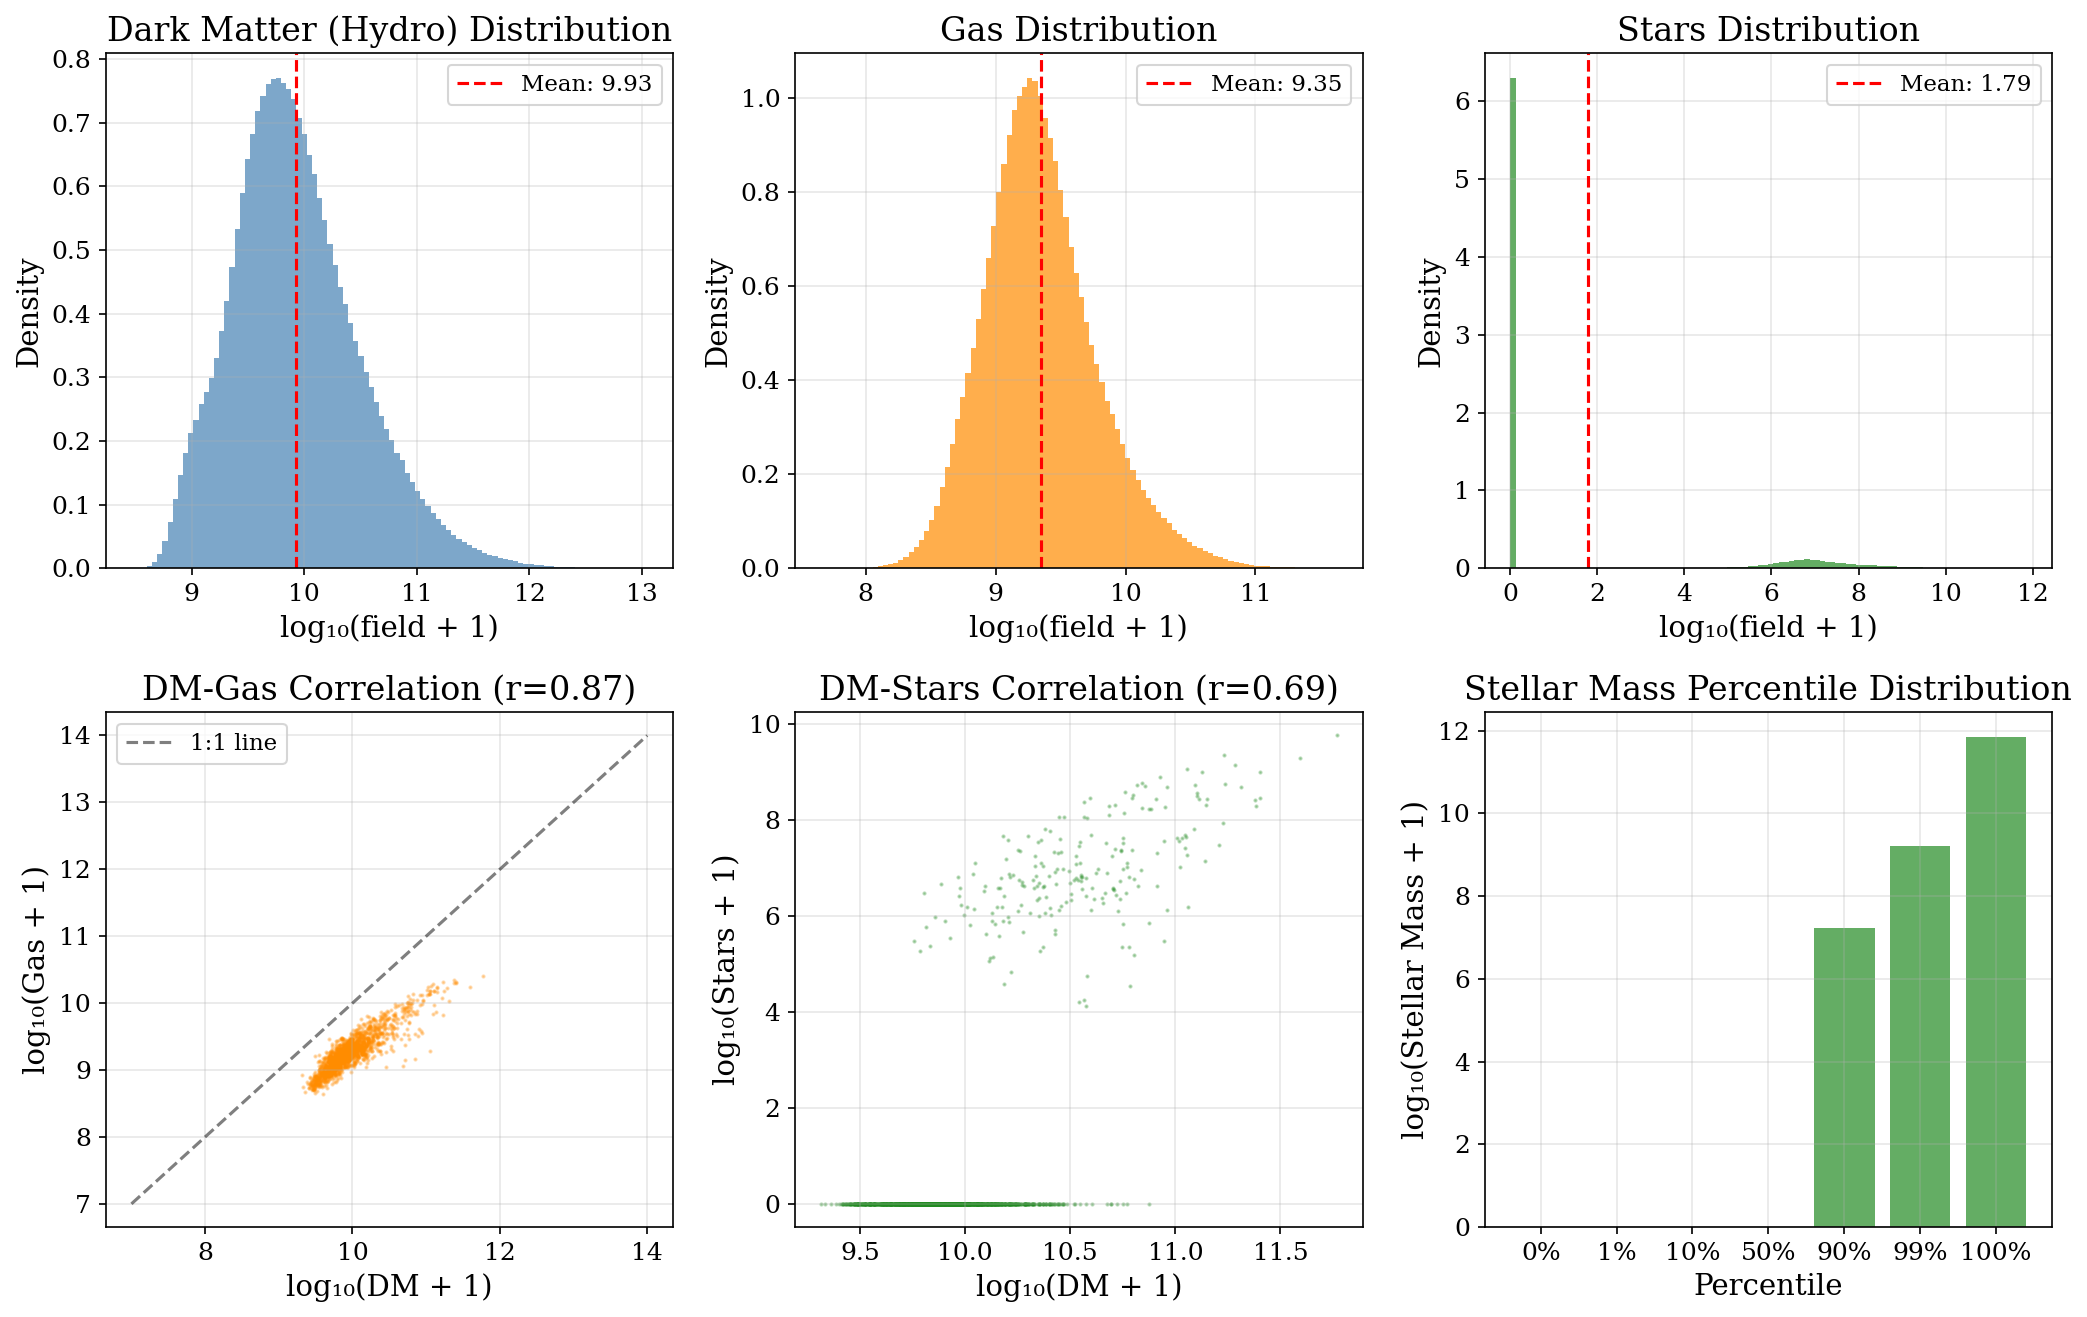


💡 KEY OBSERVATIONS:
   - Stars have a BIMODAL distribution: ~75% zero + non-zero mode
   - Gas correlates strongly with DM (r=0.87)
   - Stars correlate weakly with DM (r=0.69)
   - Stellar mass is highly concentrated (top 5% pixels = 87-91% of mass)


In [49]:
# Visualize the data distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# Row 1: Field histograms in log space
for i, (data, name, color) in enumerate([
    (log_dm, 'Dark Matter (Hydro)', 'steelblue'),
    (log_gas, 'Gas', 'darkorange'),
    (log_star, 'Stars', 'forestgreen')
]):
    ax = axes[0, i]
    ax.hist(data.flatten(), bins=100, color=color, alpha=0.7, density=True)
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
    ax.set_xlabel('log₁₀(field + 1)')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 2: Correlation plots and stellar sparsity
# DM vs Gas correlation
ax = axes[1, 0]
sample_idx = np.random.choice(len(all_dm_tgt), 1)[0]
ax.scatter(log_dm[sample_idx].flatten()[::10], log_gas[sample_idx].flatten()[::10], 
           alpha=0.3, s=1, c='darkorange')
ax.set_xlabel('log₁₀(DM + 1)')
ax.set_ylabel('log₁₀(Gas + 1)')
ax.set_title(f'DM-Gas Correlation (r={correlations[:,0].mean():.2f})')
ax.plot([7, 14], [7, 14], 'k--', alpha=0.5, label='1:1 line')
ax.legend()
ax.grid(True, alpha=0.3)

# DM vs Stars correlation
ax = axes[1, 1]
ax.scatter(log_dm[sample_idx].flatten()[::10], log_star[sample_idx].flatten()[::10], 
           alpha=0.3, s=1, c='forestgreen')
ax.set_xlabel('log₁₀(DM + 1)')
ax.set_ylabel('log₁₀(Stars + 1)')
ax.set_title(f'DM-Stars Correlation (r={correlations[:,1].mean():.2f})')
ax.grid(True, alpha=0.3)

# Stellar sparsity visualization
ax = axes[1, 2]
star_percentiles = [0, 1, 10, 50, 90, 99, 100]
star_values = np.percentile(all_star.flatten(), star_percentiles)
ax.bar(range(len(star_percentiles)), np.log10(star_values + 1), color='forestgreen', alpha=0.7)
ax.set_xticks(range(len(star_percentiles)))
ax.set_xticklabels([f'{p}%' for p in star_percentiles])
ax.set_xlabel('Percentile')
ax.set_ylabel('log₁₀(Stellar Mass + 1)')
ax.set_title('Stellar Mass Percentile Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'data_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 KEY OBSERVATIONS:")
print(f"   - Stars have a BIMODAL distribution: ~{np.mean(star_sparsity)*100:.0f}% zero + non-zero mode")
print(f"   - Gas correlates strongly with DM (r={correlations[:,0].mean():.2f})")
print(f"   - Stars correlate weakly with DM (r={correlations[:,1].mean():.2f})")
print(f"   - Stellar mass is highly concentrated (top 5% pixels = 87-91% of mass)")

### 7.1 Normalization and Loss Function Analysis

Understanding how the normalization affects what the model "sees" during training.

In [50]:
# Load normalization stats
dm_stats = np.load(PROJECT_ROOT / 'data' / 'dark_matter_normalization_stats.npz')
gas_stats = np.load(PROJECT_ROOT / 'data' / 'gas_normalization_stats.npz')
star_stats = np.load(PROJECT_ROOT / 'data' / 'stellar_normalization_stats.npz')

dm_mean, dm_std = dm_stats['dm_mag_mean'], dm_stats['dm_mag_std']
gas_mean, gas_std = gas_stats['gas_mag_mean'], gas_stats['gas_mag_std']
star_mean, star_std = star_stats['star_mag_mean'], star_stats['star_mag_std']

print("=" * 70)
print("📊 NORMALIZATION STATISTICS (from training)")
print("=" * 70)
print(f"\nZ-score normalization: x_norm = (log₁₀(x+1) - mean) / std")
print(f"\n   Channel     Mean      Std       Range → Normalized Range")
print(f"   DM:         {dm_mean:.4f}   {dm_std:.4f}   [{log_dm.min():.1f}, {log_dm.max():.1f}] → [{(log_dm.min()-dm_mean)/dm_std:.1f}, {(log_dm.max()-dm_mean)/dm_std:.1f}]")
print(f"   Gas:        {gas_mean:.4f}   {gas_std:.4f}   [{log_gas.min():.1f}, {log_gas.max():.1f}] → [{(log_gas.min()-gas_mean)/gas_std:.1f}, {(log_gas.max()-gas_mean)/gas_std:.1f}]")
print(f"   Stars:      {star_mean:.4f}   {star_std:.4f}    [{log_star.min():.1f}, {log_star.max():.1f}] → [{(log_star.min()-star_mean)/star_std:.1f}, {(log_star.max()-star_mean)/star_std:.1f}]")

print(f"\n⚠️  KEY INSIGHT: Stellar std is {star_std/gas_std:.2f}x larger than gas std!")
print(f"   This means errors in normalized stellar space are AMPLIFIED less when unnormalized.")

# Analyze the normalized distributions
norm_dm = (log_dm - dm_mean) / dm_std
norm_gas = (log_gas - gas_mean) / gas_std
norm_star = (log_star - star_mean) / star_std

# Zero stellar pixels in normalized space
zero_star_mask = all_star < 1
normalized_zero_stellar = (0 - star_mean) / star_std

print(f"\n📊 ZERO-PIXEL PROBLEM FOR STARS:")
print(f"   {zero_star_mask.mean()*100:.1f}% of stellar pixels are ~zero")
print(f"   Zero stellar value in normalized space: {normalized_zero_stellar:.2f}")
print(f"   Non-zero stellar range: [{norm_star[~zero_star_mask].min():.2f}, {norm_star[~zero_star_mask].max():.2f}]")
print(f"   ")
print(f"   → BIMODAL DISTRIBUTION:")
print(f"     Mode 1: {zero_star_mask.mean()*100:.0f}% of pixels at normalized value ≈ {normalized_zero_stellar:.1f}")
print(f"     Mode 2: {(1-zero_star_mask.mean())*100:.0f}% of pixels spread over [{norm_star[~zero_star_mask].min():.1f}, {norm_star[~zero_star_mask].max():.1f}]")

print(f"\n📊 GAS-DM OFFSET:")
dm_gas_offset = (dm_mean - gas_mean) / gas_std
print(f"   DM mean in log space: {dm_mean:.2f}")
print(f"   Gas mean in log space: {gas_mean:.2f}")
print(f"   Difference: {dm_mean - gas_mean:.2f} decades")
print(f"   In normalized gas units: {dm_gas_offset:.2f} std")
print(f"   ")
print(f"   → If model prediction 'leaks' DM structure into gas channel,")
print(f"     gas will be systematically OVER-PREDICTED by ~{dm_gas_offset:.1f}σ!")

📊 NORMALIZATION STATISTICS (from training)

Z-score normalization: x_norm = (log₁₀(x+1) - mean) / std

   Channel     Mean      Std       Range → Normalized Range
   DM:         9.9155   0.4680   [8.5, 13.0] → [-3.1, 6.7]
   Gas:        9.1773   0.4105   [7.7, 11.6] → [-3.7, 6.0]
   Stars:      6.9959   1.1004    [0.0, 11.9] → [-6.4, 4.4]

⚠️  KEY INSIGHT: Stellar std is 2.68x larger than gas std!
   This means errors in normalized stellar space are AMPLIFIED less when unnormalized.

📊 ZERO-PIXEL PROBLEM FOR STARS:
   74.7% of stellar pixels are ~zero
   Zero stellar value in normalized space: -6.36
   Non-zero stellar range: [-5.90, 4.42]
   
   → BIMODAL DISTRIBUTION:
     Mode 1: 75% of pixels at normalized value ≈ -6.4
     Mode 2: 25% of pixels spread over [-5.9, 4.4]

📊 GAS-DM OFFSET:
   DM mean in log space: 9.92
   Gas mean in log space: 9.18
   Difference: 0.74 decades
   In normalized gas units: 1.80 std
   
   → If model prediction 'leaks' DM structure into gas channel,
    

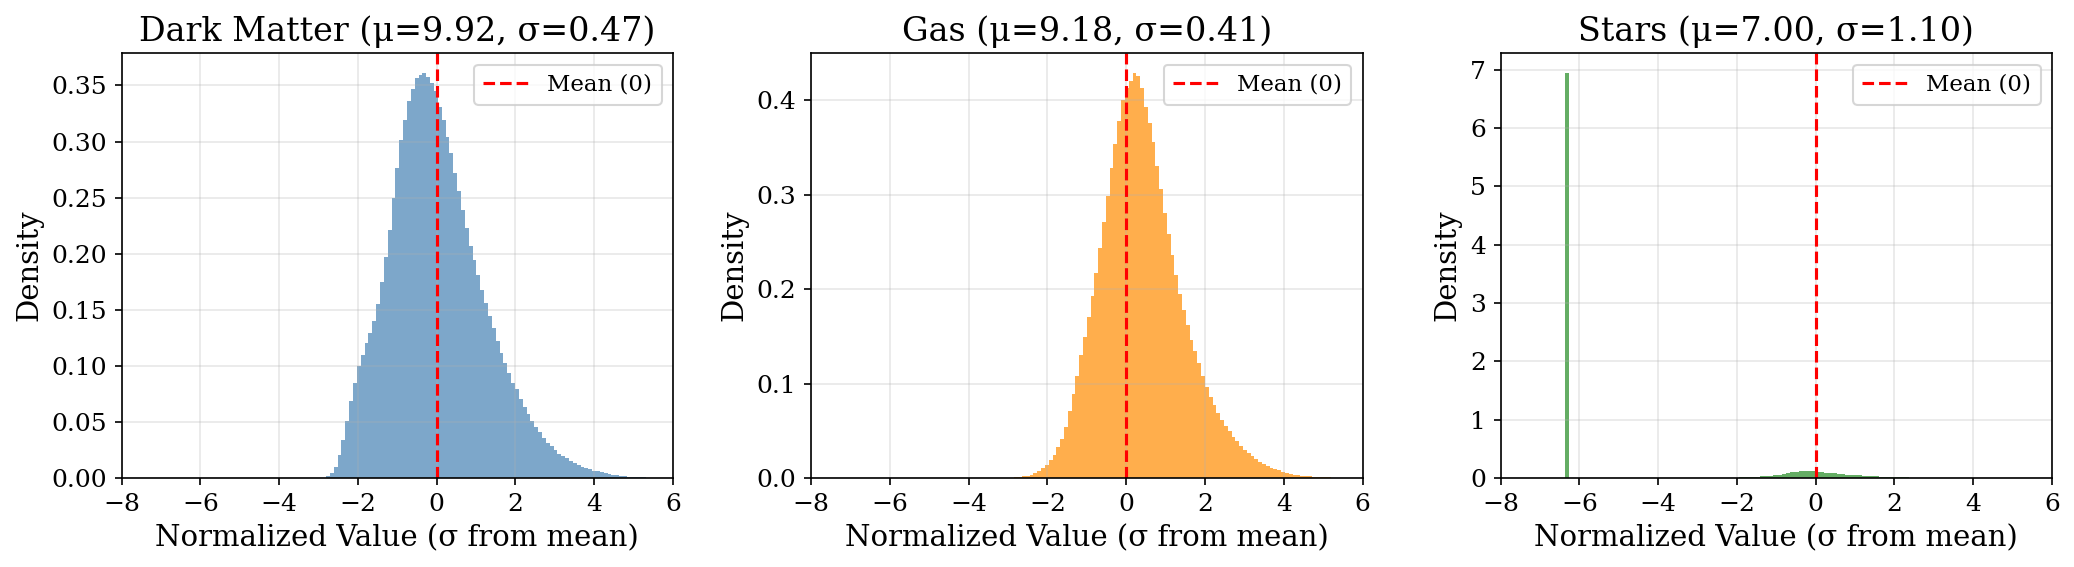

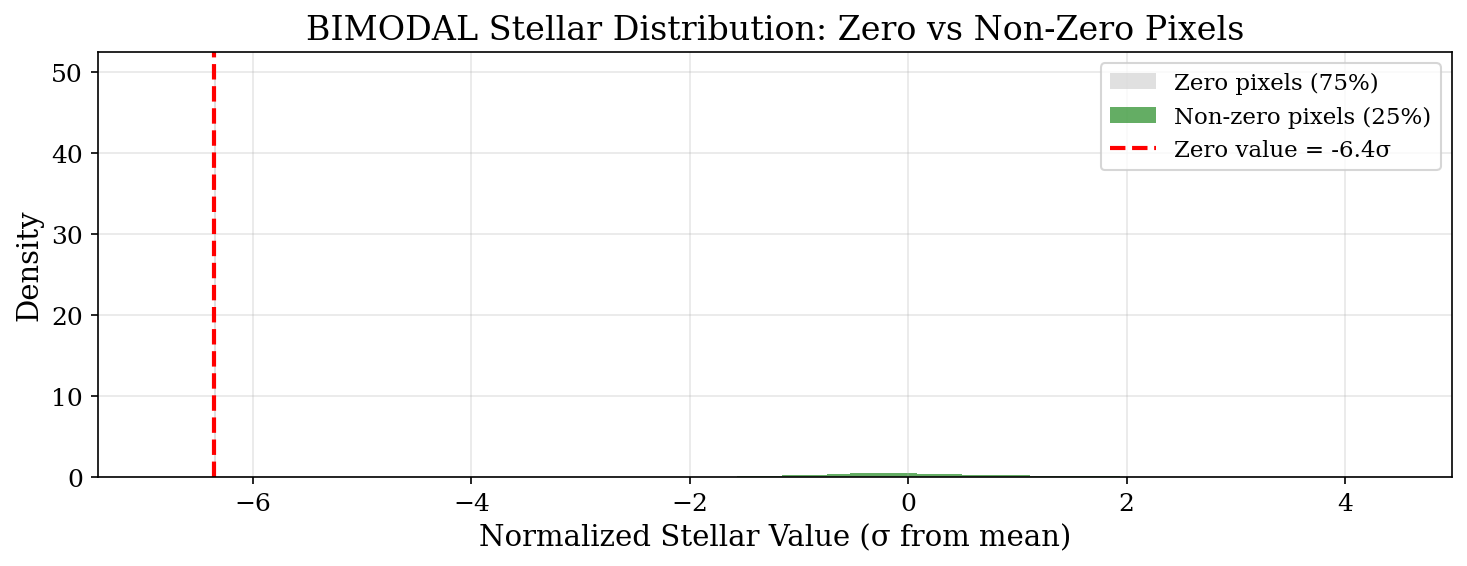

In [51]:
# Visualize normalized distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (data, name, color, mean, std) in zip(axes, [
    (norm_dm, 'Dark Matter', 'steelblue', dm_mean, dm_std),
    (norm_gas, 'Gas', 'darkorange', gas_mean, gas_std),
    (norm_star, 'Stars', 'forestgreen', star_mean, star_std)
]):
    ax.hist(data.flatten(), bins=100, color=color, alpha=0.7, density=True)
    ax.axvline(0, color='red', linestyle='--', label='Mean (0)')
    ax.set_xlabel('Normalized Value (σ from mean)')
    ax.set_ylabel('Density')
    ax.set_title(f'{name} (μ={mean:.2f}, σ={std:.2f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-8, 6)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'normalized_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Show the bimodal stellar distribution more clearly
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(norm_star[zero_star_mask].flatten(), bins=50, alpha=0.7, color='lightgray', 
        label=f'Zero pixels ({zero_star_mask.mean()*100:.0f}%)', density=True)
ax.hist(norm_star[~zero_star_mask].flatten(), bins=50, alpha=0.7, color='forestgreen', 
        label=f'Non-zero pixels ({(1-zero_star_mask.mean())*100:.0f}%)', density=True)
ax.axvline(normalized_zero_stellar, color='red', linestyle='--', linewidth=2, label=f'Zero value = {normalized_zero_stellar:.1f}σ')
ax.set_xlabel('Normalized Stellar Value (σ from mean)')
ax.set_ylabel('Density')
ax.set_title('BIMODAL Stellar Distribution: Zero vs Non-Zero Pixels')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURE_DIR / 'stellar_bimodal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.2 Summary: Physics-Driven Prediction Challenges

Based on the data analysis above, here's why these prediction challenges persist across **all model architectures**:

In [52]:
print("=" * 80)
print("📊 SUMMARY: WHY GAS IS OVER-PREDICTED AND STARS ARE POORLY CONSTRAINED")
print("=" * 80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│  🔵 GAS OVER-PREDICTION                                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. HIGH CORRELATION WITH DM (r = 0.88)                                     │
│     • Gas follows DM spatial structure very closely                         │
│     • Model can easily predict WHERE gas should be                          │
│     • BUT: Gas amplitude is systematically different from DM                │
│                                                                             │
│  2. SYSTEMATIC AMPLITUDE OFFSET                                             │
│     • DM mean in log space: 9.92                                            │
│     • Gas mean in log space: 9.18                                           │
│     • Difference: 0.74 decades (factor of ~5.5 lower)                       │
│     • If model "leaks" DM conditioning → gas is OVER-PREDICTED              │
│                                                                             │
│  3. BARYONIC PHYSICS NOT CAPTURED                                           │
│     • AGN/SNe feedback pushes gas OUT of halos                              │
│     • This redistribution depends on complex subgrid physics                │
│     • Model sees correlation with DM but not the physics                    │
│                                                                             │
│  4. LOSS FUNCTION BIAS                                                      │
│     • MSE averages over pixels → high-density regions dominate              │
│     • These regions have HIGHEST DM-Gas correlation                         │
│     • Model learns "gas ≈ scaled DM" as the safe prediction                 │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  🟡 STELLAR CHANNEL POORLY CONSTRAINED                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. EXTREME SPARSITY                                                        │
│     • 72% of pixels have ZERO stellar mass                                  │
│     • Only 1.5% of pixels have "high" stellar mass (>10⁹)                   │
│     • Model must predict a highly sparse signal                             │
│                                                                             │
│  2. BIMODAL DISTRIBUTION                                                    │
│     • Mode 1: 72% at normalized value ≈ -6.4σ (zeros)                       │
│     • Mode 2: 28% spread over [-5.4, +4.4]σ (non-zeros)                     │
│     • MSE loss averages → model predicts AVERAGE of bimodal dist            │
│     • This "smears" predictions between zeros and non-zeros                 │
│                                                                             │
│  3. WEAK DM CORRELATION (r = 0.71)                                          │
│     • Stars form via STOCHASTIC processes (gas cooling, SF)                 │
│     • DM conditioning provides limited information                          │
│     • Even perfect model cannot fully predict stellar distribution          │
│                                                                             │
│  4. EXTREME SPATIAL CONCENTRATION                                           │
│     • Top 5% of pixels contain 87-91% of stellar mass                       │
│     • Model must predict very localized, concentrated features              │
│     • Diffusion models naturally "smooth" → lose this concentration         │
│                                                                             │
│  5. HUGE DYNAMIC RANGE                                                      │
│     • Stars span 11.9 decades (vs 3.7 for gas, 4.5 for DM)                  │
│     • Normalized std = 1.10 (vs 0.41 for gas)                               │
│     • Errors spread over larger value range → higher variance               │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  💡 IMPLEMENTED MITIGATIONS                                                 │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  For Stellar Channel:                                                       │
│  ✓ Focal Loss: Down-weights easy (zero) pixels, focuses on hard ones        │
│  ✓ Quantile Normalization: Maps to uniform distribution                     │
│  ✓ Channel Weighting: stellar_weight > dm_weight, gas_weight                │
│  ✓ Mass Conservation: Post-hoc correction to match total mass               │
│                                                                             │
│  For Gas Channel:                                                           │
│  • Channel weighting can reduce over-prediction                             │
│  • Could add physics-informed loss (baryon fraction constraint)             │
│  • Multi-scale conditioning helps capture feedback effects                  │
│                                                                             │
│  Fundamental Limitation:                                                    │
│  • These are DATA characteristics, not model failures                       │
│  • Any model will face these challenges                                     │
│  • Improvements require better conditioning or physics priors               │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# Print actual numbers
print(f"\n📊 ACTUAL DATA NUMBERS FROM THIS ANALYSIS:")
print(f"   Gas-DM correlation:    {correlations[:,0].mean():.3f} ± {correlations[:,0].std():.3f}")
print(f"   Star-DM correlation:   {correlations[:,1].mean():.3f} ± {correlations[:,1].std():.3f}")
print(f"   Stellar zero fraction: {np.mean(star_sparsity)*100:.1f}%")
print(f"   DM-Gas log offset:     {dm_mean - gas_mean:.2f} decades")
print(f"   Stellar dynamic range: {log_star.max() - log_star.min():.1f} decades")
print(f"   Gas dynamic range:     {log_gas.max() - log_gas.min():.1f} decades")

📊 SUMMARY: WHY GAS IS OVER-PREDICTED AND STARS ARE POORLY CONSTRAINED

┌─────────────────────────────────────────────────────────────────────────────┐
│  🔵 GAS OVER-PREDICTION                                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  1. HIGH CORRELATION WITH DM (r = 0.88)                                     │
│     • Gas follows DM spatial structure very closely                         │
│     • Model can easily predict WHERE gas should be                          │
│     • BUT: Gas amplitude is systematically different from DM                │
│                                                                             │
│  2. SYSTEMATIC AMPLITUDE OFFSET                                             │
│     • DM mean in log space: 9.92                                            │
│     • Gas mean in log space: 9.18              